In [1]:
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from compute_functions import *
import numpy as np
import dash_bio
from sklearn.preprocessing import MinMaxScaler


In [2]:
def load_data(path: str):
    df = pd.read_csv(path,sep = '\t')
    return df

In [3]:
analysis_df = load_data("analysis_output.txt")
analysis_df

Protein                Label2    log2FC       FDR  Imputed.FDR
0     A0A075B6I0       northstar-vital -0.149104  0.634552     0.751618
1     A0A075B6J9       northstar-vital  0.207513  0.719085     0.814194
2     A0A075B6Q5       northstar-vital  0.026124  0.934831     0.962075
3     A0A075B6R2       northstar-vital -0.554774  0.244685     0.454760
4     A0A0A0MS15       northstar-vital -0.357852  0.274311     0.483844
...          ...                   ...       ...       ...          ...
1769      Q9Y646  individual-northstar  0.681010  0.225884     0.940784
1770      Q9Y678  individual-northstar  0.343619  0.483667     0.940784
1771      Q9Y696  individual-northstar -0.126557  0.828351     0.978492
1772      Q9Y6B6  individual-northstar -0.094270  0.793641     0.978492
1773      Q9Y6Y9  individual-northstar  0.243777  0.123218     0.940784

[1774 rows x 5 columns]

In [4]:
#exisiting implementation 
def get_uniprot_info(pt_level):

    NoSplitRequired = None
    proteins = list(set(pt_level['Protein'].tolist()))
    protein_names = []

    #removes fasta descriptions if present
    for protein_name in proteins:
        pt = _get_uniprot_ids(protein_name)
        protein_names.append(pt)

    #splitting protein list into separate lists since the Uniprot API only allows queries under a certain size
    chunk_size = 130
    if len(protein_names) > chunk_size:
        split_list = []
        for i in range(0, len(protein_names), chunk_size):
            split_list.append(protein_names[i:i+chunk_size])
    else:
        NoSplitRequired = True
        split_list = [protein_names]

    #defining columns to retrieve from uniprot: https://www.uniprot.org/help/return_fields
    cols = ["accession", "gene_primary","protein_name","cc_tissue_specificity","go_p","go_c","go_f","cc_subcellular_location"]
    cols = ",".join(cols)

    entries_list = get_uniprot_entries(protein_names, split_list, cols)

    if len(entries_list) != 0:
        #change the column headers
        df_cols = ["ProteinIds","Gene Name", "Protein Description", "Tissue Specificity","Gene ontology (biological process)","Gene ontology (cellular component)","Gene ontology (molecular function)","Subcellular Location[CC]"]
        uniprot_df = pd.DataFrame(entries_list, columns=df_cols)

    else:
        print("Couldn't fetch UniProt Annotation at the moment.")

    return uniprot_df

## helper functions
def _get_uniprot_ids(row):
        REGEX_UNIPROTID = re.compile("iRT|([A-N,R-Z][0-9]([A-Z][A-Z, 0-9][A-Z, 0-9][0-9]){1,2})|([O,P,Q][0-9][A-Z, 0-9][A-Z, 0-9][A-Z, 0-9][0-9])(\.\d+)?")
        result = re.search(REGEX_UNIPROTID, row)
        if result is None:
                pt = row
        else:
                pt = result.group(0)
        return pt

def get_uniprot_entries(protein_names, split_list, cols):

    def get_next_link(headers):
        if "Link" in headers:
            match = re_next_link.match(headers["Link"])
            if match:
                return match.group(1)

    def get_batch(batch_url):
        while batch_url:
            response = session.get(batch_url)
            response.raise_for_status()
            total = response.headers["x-total-results"]
            yield response, total
            batch_url = get_next_link(response.headers)

    re_next_link = re.compile(r'<(.+)>; rel="next"')
    retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
    session = requests.Session()
    session.mount("https://", HTTPAdapter(max_retries=retries))

    entries = []

    for protein_list in split_list:
        query_proteins = "+OR+".join(protein_list)
        url = f'https://rest.uniprot.org/uniprotkb/search?fields={cols}&size=300&format=tsv&query={query_proteins}'

        for batch,total in get_batch(url):
            for line in batch.text.splitlines()[1:]:
                line = line.split("\t")
                if line[0] not in protein_names:
                    continue
                if line not in entries:
                    entries.append(line)

    return entries


In [5]:
%%time
uniprot_annotation = get_uniprot_info(analysis_df)

CPU times: total: 516 ms
Wall time: 59.9 s


In [6]:
uniprot_annotation

ProteinIds  Gene Name                                Protein Description  \
0        Q06323      PSME1  Proteasome activator complex subunit 1 (11S re...   
1        B2RUZ4      SMIM1  Small integral membrane protein 1 (Vel blood g...   
2        O00300  TNFRSF11B  Tumor necrosis factor receptor superfamily mem...   
3        O00487     PSMD14  26S proteasome non-ATPase regulatory subunit 1...   
4        O60266      ADCY3  Adenylate cyclase type 3 (EC 4.6.1.1) (ATP pyr...   
..          ...        ...                                                ...   
653      P04004        VTN  Vitronectin (VN) (S-protein) (Serum-spreading ...   
654      P04066      FUCA1  Tissue alpha-L-fucosidase (EC 3.2.1.51) (Alpha...   
655      P62834      RAP1A  Ras-related protein Rap-1A (EC 3.6.5.2) (C21KG...   
656      P22102       GART  Trifunctional purine biosynthetic protein aden...   
657  A0A075B6J9   IGLV2-18                Immunoglobulin lambda variable 2-18   

                                    Tissue Specificity  \
0                                                        
1    TISSUE SPECIFICITY: Highly expressed in the bo...   
2    TISSUE SPECIFICITY: Highly expressed in adult ...   
3    TISSUE SPECIFICITY: Widely expressed. Highest ...   
4    TISSUE SPECIFICITY: Detected in zona glomerulo...   
..                                                 ...   
653  TISSUE SPECIFICITY: Expressed in the retina pi...   
654                                                      
655                                                      
656                                                      
657                                                      

                    Gene ontology (biological process)  \
0    antigen processing and presentation of exogeno...   
1                                                        
2    apoptotic process [GO:0006915]; extracellular ...   
3    double-strand break repair via homologous reco...   
4    acrosome reaction [GO:0007340]; adenylate cycl...   
..                                                 ...   
653  cell adhesion [GO:0007155]; cell adhesion medi...   
654  fucose metabolic process [GO:0006004]; glycoli...   
655  cellular response to cAMP [GO:0071320]; cellul...   
656  'de novo' AMP biosynthetic process [GO:0044208...   
657  adaptive immune response [GO:0002250]; immune ...   

                    Gene ontology (cellular component)  \
0    cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...   
1    cell surface [GO:0009986]; plasma membrane [GO...   
2    extracellular matrix [GO:0031012]; extracellul...   
3    cytosol [GO:0005829]; cytosolic proteasome com...   
4    ciliary membrane [GO:0060170]; cilium [GO:0005...   
..                                                 ...   
653  alphav-beta3 integrin-vitronectin complex [GO:...   
654  azurophil granule lumen [GO:0035578]; cytoplas...   
655  anchoring junction [GO:0070161]; cell junction...   
656  cytosol [GO:0005829]; extracellular exosome [G...   
657  extracellular space [GO:0005615]; immunoglobul...   

                    Gene ontology (molecular function)  \
0        endopeptidase activator activity [GO:0061133]   
1       protein homodimerization activity [GO:0042803]   
2    cytokine activity [GO:0005125]; heparan sulfat...   
3    endopeptidase activator activity [GO:0061133];...   
4    adenylate cyclase activity [GO:0004016]; ATP b...   
..                                                 ...   
653  collagen binding [GO:0005518]; extracellular m...   
654           alpha-L-fucosidase activity [GO:0004560]   
655  G protein activity [GO:0003925]; GDP binding [...   
656  ATP binding [GO:0005524]; metal ion binding [G...   
657                                                      

                              Subcellular Location[CC]  
0                                                       
1    SUBCELLULAR LOCATION: Cell membrane {ECO:00002...  
2                      SUBCELLULAR LOCATION: Secreted.  
3               

In [7]:
#once uniprot annotation is generated, need to merge the two datasets. 
analysis_withAnnotation = merge_uniprot2proteome(analysis_df, uniprot_annotation)

In [9]:
def merge_uniprot2proteome(pt_level, uniprot_df):

    pt_level['ProteinIds'] = pt_level['Protein'].apply(_get_uniprot_ids)
    pt_level = pd.merge(uniprot_df, pt_level, on="ProteinIds", how="right")
    
    return pt_level

In [11]:
##################
#CONSTANTS
#################
COL_DEPLABEL = 'Label2'
COL_DEPSIGNIF = 'Imputed.FDR'
color_map = {
        'Down-regulated': '#0072B2',
        'Significant, no change': '#F0E442',
        'Up-regulated': '#D55E00',
        'Non-significant': '#999999'
    }
log2fc_threshold = 0.6
fdr_threshold=0.05 

In [14]:
##preprocessing for volcano plots 
def volcano_preprocess(df, COL_DEPLABEL ):
    condition_level = sorted(df[COL_DEPLABEL].unique())
    df[COL_DEPLABEL] = pd.Categorical(df[COL_DEPLABEL], categories=condition_level, ordered=True)
    condition_groups = {condition: group for condition, group in df.groupby(COL_DEPLABEL)}
    return condition_groups

In [15]:
def plot_volcano(df, FC, p_val):
    # Creating the plot
    df['sig'] = -np.log10(df[COL_DEPSIGNIF])

    df['label'] = 'Non-significant'
    df.loc[df[COL_DEPSIGNIF] <= p_val, 'label'] = 'Significant, no change'
    df.loc[(df[COL_DEPSIGNIF] <= p_val) & (df['log2FC'] > FC), 'label'] = 'Up-regulated'
    df.loc[(df[COL_DEPSIGNIF] <= p_val) & (df['log2FC'] < -FC), 'label'] = 'Down-regulated'

    fig = px.scatter(df, x='log2FC', y='sig', color='label', color_discrete_map=color_map, hover_data=['Gene Name', 'Protein Description'])
        
        # Customizing the layout
    fig.update_layout(title=f'Volcano Plot', xaxis_title="log2 fold change", yaxis_title="-log10(FDR)", legend_title_text='Category')
        
        # Adding horizontal and vertical lines for cutoffs
    fig.add_shape(type="line", x0=-FC, y0=0, x1=-FC, y1=df['sig'].max(), line=dict(color="RoyalBlue", width=2, dash="dot"))
    fig.add_shape(type="line", x0=FC, y0=0, x1=FC, y1=df['sig'].max(), line=dict(color="RoyalBlue", width=2, dash="dot"))
    fig.add_shape(type="line", x0=df['log2FC'].min(), y0=-np.log10(p_val), x1=df['log2FC'].max(), y1=-np.log10(p_val),line=dict(color="Red", width=2, dash="dot"))

    return fig 

In [37]:
fig = plot_volcano(condition_groups["northstar-vital"], log2fc_threshold, fdr_threshold)
fig.show()

## full volcano flow
step 1: read in your analysis output file [ understand what this file is, how it's generated and what information you can get from this ]

step 2: Get uniprot information for your proteins in the analysis_output, and merge the two files. 

step 3: assign your constant values and thresholds [ understand the columns, the thershold values and why they are recommended ]

step 4: preprocess your merged_analysis_with_Annotation to get your condition groups sub df 

step 5: call your plot_volcano function with the threshold values. 

C:\Users\admin-bharadwaja\AppData\Local\Temp\2\ipykernel_11840\1762252404.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  condition_groups = {condition: group for condition, group in df.groupby(COL_DEPLABEL)}


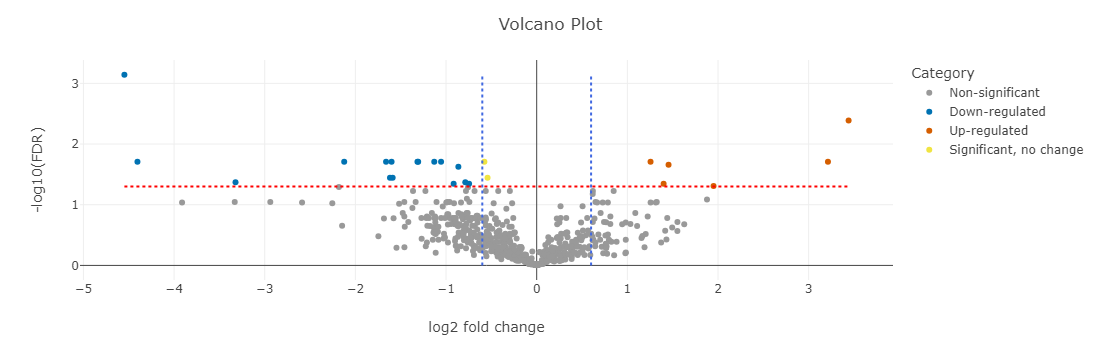

CPU times: total: 812 ms
Wall time: 8.71 s


In [16]:
%%time
analysis_df = load_data("analysis_output.txt")
uniprot_annotation = get_uniprot_info(analysis_df)
analysis_withAnnotation = merge_uniprot2proteome(analysis_df, uniprot_annotation)
condition_groups = volcano_preprocess(analysis_withAnnotation, COL_DEPLABEL)
fig = plot_volcano(condition_groups["northstar-vital"], log2fc_threshold, fdr_threshold)
fig.show()

## heatmap flow? using dash bio? clustergram? 
## For heatmaps, you are using the analysis output to get the top 10 differentially expressed proteins. and you are then plotting the intensity values of those proteins in heatmap - check what log transformations you need to do for these heatmaps. 



In [17]:
def plot_heatmap(df):

    #need to set the index and scale it before plotting. 
    df = df.set_index('Protein')
    #df = df.drop('Protein', axis=1)

    scaler = MinMaxScaler()
    df1_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


    fig = dash_bio.Clustergram(
    data=df1_norm,
    column_labels=list(df1_norm.columns.values),
    row_labels=list(df1_norm.index),
    height=600,
    width=600
    )
    
    fig.update_layout(title=f'Heatmap', xaxis_title="samples", yaxis_title="Proteins")

    return fig

In [19]:
df = condition_groups["northstar-vital"]
dep_list_df = df[(df['Imputed.FDR'] < heatmap_fdr_threshold) & ((df['log2FC'] < heatmap_log2fc_threshold) | (df['log2FC'] > heatmap_log2fc_threshold)) ]

In [18]:
###heatmap constants 
heatmap_fdr_threshold = 0.05
heatmap_log2fc_threshold = 0.6

In [120]:
top_10_df

Protein  Individual_Vital_28_1  Individual_Vital_29_1  \
162  P02794           1.558450e+06           8.515477e+05   
167  P04066           5.067264e+05           7.386128e+05   
170  P04083           7.087900e+05           3.738475e+05   
183  P05154           2.864629e+05           1.569347e+05   
199  P06702           1.953398e+05           1.045462e+06   
211  P07437           3.033208e+05           0.000000e+00   
218  P07996           2.097152e+06           1.313740e+06   
516  P62805           3.811704e+05           6.195084e+05   
576  Q14512           1.392389e+06           4.159357e+05   
763  Q9Y2J8           2.058895e+06           9.678820e+05   

     Individual_Vital_30_1  Individual_Vital_31_1  Individual_Vital_32_1  \
162           1.832947e+06           0.000000e+00           4.006363e+05   
167           0.000000e+00           1.965537e+06           2.799127e+05   
170           4.312022e+05           0.000000e+00           0.000000e+00   
183           1.839846e+06           3.417179e+06           5.249088e+05   
199           2.719573e+06           0.000000e+00           4.973544e+05   
211           4.327473e+05           0.000000e+00           0.000000e+00   
218           1.140244e+06           6.415043e+05           1.515919e+06   
516           1.616719e+06           0.000000e+00           3.220598e+05   
576           5.266923e+05           6.816751e+05           2.607427e+05   
763           2.571388e+06           9.747934e+05           0.000000e+00   

     Northstar_QC_P1_1  Northstar_QC_P1_2  Northstar_QC_P2_1  \
162       6.340868e+05       0.000000e+00       4.179654e+05   
167       3.667124e+06       2.850813e+06       2.158383e+06   
170       0.000000e+00       1.565317e+05       0.000000e+00   
183       2.035995e+06       1.110767e+06       1.606584e+06   
199       4.414759e+05       1.694164e+05       2.124711e+05   
211       2.466902e+05       2.554745e+05       0.000000e+00   
218       7.258082e+05       0.000000e+00       9.841129e+05   
516       5.897724e+05       4.148970e+05       4.150006e+05   
576       2.888246e+06       2.647699e+06       2.502603e+06   
763       0.000000e+00       0.000000e+00       0.000000e+00   

     Northstar_QC_P2_2  Vital_QC_P1_1  Vital_QC_P1_2  Vital_QC_P2_1  \
162       4.351854e+05   1.630118e+06   1.435721e+06   1.426816e+06   
167       3.157835e+06   2.787824e+05   3.642391e+05   2.653234e+05   
170       1.489376e+05   1.369550e+06   1.695783e+06   1.255059e+06   
183       1.886828e+06   4.983595e+05   4.814978e+05   2.555348e+05   
199       2.363612e+05   7.763518e+06   9.713433e+06   1.932483e+06   
211       0.000000e+00   8.574066e+05   7.059434e+05   3.639447e+05   
218       8.315759e+05   2.816839e+06   2.773670e+06   2.388898e+06   
516       5.526072e+05   1.102627e+07   1.224613e+07   9.968160e+06   
576       3.296659e+06   3.686322e+05   3.588116e+05   0.000000e+00   
763       4.454030e+05   2.235902e+06   2.349731e+06   1.928499e+06   

     Vital_QC_P2_2  
162   1.588880e+06  
167   1.903609e+05  
170   1.865503e+06  
183   5.005939e+05  
199   5.177501e+06  
211   4.046631e+05  
218   2.639472e+06  
516   1.248366e+07  
576   2.294700e+05  
763   1.952006e+06

In [71]:
pt_level = load_data("protein_level.txt")

In [28]:
dep_list_df['abs_log2FC'] = dep_list_df['log2FC'].abs()  # Create a new column with the absolute values of log2FC
top10_by_fc = dep_list_df.sort_values(by='abs_log2FC', ascending=False).head(10)
top_10_df = pt_level[pt_level['Protein'].isin(list(top10_by_fc['Protein'])[:10])]

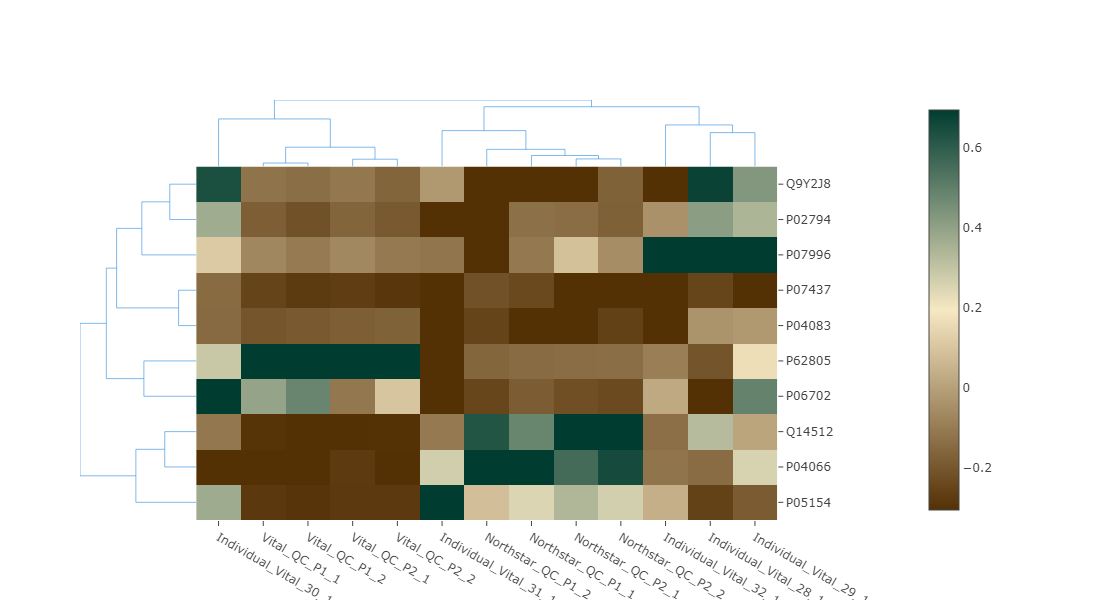

In [29]:
fig = plot_heatmap(top_10_df)
fig.show()

In [39]:
top_10genes = top_10_df['Protein'].to_list()

In [27]:
pt_level.replace([np.inf, -np.inf], np.nan, inplace=True)
pt_level.fillna(0, inplace=True)

In [30]:
def process_annotation_info(annotation_info, SAMPLENAME, GROUPING, LIMIT_SAMPLE_COMPARISONS, protein_info=None, PROVIDED_ProteinLevelInfo=False):
    
    # 1. Transform `annotation_info` into a DataFrame, select necessary columns, rename, and handle missing groups
    annotation_info = annotation_info.copy()
    annotation_info = annotation_info[[SAMPLENAME, GROUPING]].rename(columns={SAMPLENAME: 'SampleName', GROUPING: 'Group'})
    
    # Replace missing or empty Group values with "NOT_ANNOTATED"
    annotation_info['Group'] = annotation_info['Group'].replace(['', np.nan], 'NOT_ANNOTATED')

    # 2. Automatically limit sample comparisons if more than 5 unique groups
    if len(annotation_info['Group'].unique()) > 5 and not LIMIT_SAMPLE_COMPARISONS:
        LIMIT_SAMPLE_COMPARISONS = True
        print("Warning: There are greater than 5 sample groups for this job. --limit_comparisons is automatically turned ON to reduce visual clutter.", file=sys.stderr)

    # 3. Check for duplicated SampleNames
    if annotation_info['SampleName'].duplicated().any():
        dups = annotation_info.loc[annotation_info['SampleName'].duplicated(keep=False), 'SampleName'].unique()
        raise ValueError(f"Duplicated sample names found in the annotation file:\n\t{', '.join(dups)}")

    # 4. Check for missing values in SampleName and Group
    if annotation_info[['SampleName', 'Group']].isna().any().any():
        raise ValueError(f"No missing values allowed in the annotation file.")

    # 5. Validate samples against protein_info if provided
    if PROVIDED_ProteinLevelInfo:
        # Check for samples in protein_info that are not annotated
        not_annotated = [sample for sample in protein_info.index if sample not in annotation_info['SampleName'].values]
        if not_annotated:
            raise ValueError(f"The following samples are not annotated in the annotation file:\n\t{', '.join(not_annotated)}")

        # Discard extra annotation entries not present in protein_info
        extra_annotation = annotation_info[~annotation_info['SampleName'].isin(protein_info.index)]
        if not extra_annotation.empty:
            annotation_info = annotation_info[annotation_info['SampleName'].isin(protein_info.index)]
            print(f"Warning: Annotation file contains entries not present in ProteinLevelInfo, which will be discarded:\n\t{', '.join(extra_annotation['SampleName'])}", file=sys.stderr)

    return annotation_info, LIMIT_SAMPLE_COMPARISONS

In [31]:
annotation_df = pd.read_csv("Annotation.txt", sep='\t')
annotation_df.head()

Filename  \
0  /hpc/home/vaneykjlab/Proepic_training_2023/dat...   
1  /hpc/home/vaneykjlab/Proepic_training_2023/dat...   
2  /hpc/home/vaneykjlab/Proepic_training_2023/dat...   
3  /hpc/home/vaneykjlab/Proepic_training_2023/dat...   
4  /hpc/home/vaneykjlab/Proepic_training_2023/dat...   

  attribute_ExperimentalGroup attribute_BiologicalGroup  \
0                   Northstar                     QC_P2   
1                       Vital                     QC_P2   
2                   Northstar                     QC_P1   
3                  Individual                  Vital_31   
4                   Northstar                     QC_P2   

   attribute_TechnicalGroup attribute_DataType attribute_SampleType  \
0                         1                DIA           Breastmilk   
1                         1                DIA           Breastmilk   
2                         1                DIA           Breastmilk   
3                         1                DIA           Breastmilk   
4                         2                DIA           Breastmilk   

  attribute_Species               Level2                 Level3  ms_batch  \
0             Human      Northstar_QC_P2      Northstar_QC_P2_1         1   
1             Human          Vital_QC_P2          Vital_QC_P2_1         1   
2             Human      Northstar_QC_P1      Northstar_QC_P1_1         1   
3             Human  Individual_Vital_31  Individual_Vital_31_1         1   
4             Human      Northstar_QC_P2      Northstar_QC_P2_2         1   

   digestion_batch  other_batch        Date      Time  Order  
0                2          NaN  2023-04-18  12:04:00      1  
1                2          NaN  2023-04-18  12:04:09      2  
2                1          NaN  2023-04-18  12:04:10      3  
3                1          NaN  2023-04-18  12:04:11      4  
4                2          NaN  2023-04-18  12:04:11      5

In [32]:
##annotation constants 
SAMPLENAME = "Level3"
GROUPING = "attribute_ExperimentalGroup"

In [34]:
annotation_info, LIMIT_SAMPLE_COMPARISONS = process_annotation_info(annotation_df, SAMPLENAME, GROUPING, "False")

In [40]:
top_10genes = top_10_df['Protein'].to_list() 

In [ ]:
top_10_df = pt_level[pt_level['Protein'].isin(list(top10_by_fc['Protein'])[:10])]

In [72]:
df = pt_level.copy()
df = df.set_index('Protein')
    #df = df.drop('Protein', axis=1)

scaler = MinMaxScaler()
df1_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

ValueError: could not convert string to float: 'A0A075B6I0'

In [96]:
violin_df = df.T[top_10genes]

In [76]:
merged_df = pd.merge(violin_df, annotation_info, left_index=True, right_on="SampleName")


In [77]:
melted_df = pd.melt(merged_df, id_vars=["SampleName", "Group"], var_name="UniprotID", value_name="Intensity")

In [97]:
merged_df = pd.merge(violin_df, annotation_info, left_index=True, right_on="SampleName")
melted_df = pd.melt(merged_df, id_vars=["SampleName", "Group"], var_name="UniprotID", value_name="Intensity")

In [83]:
fig = go.Figure()

# 7. Iterate over unique groups and add a violin trace for each group
for group in melted_df['Group'].unique():
    group_data = melted_df[melted_df['Group'] == group]
    fig.add_trace(go.Violin(
        x=group_data['Group'],
        y=group_data['Intensity'],
        name=group,
        box_visible=True,  # Show the boxplot within the violin plot
        meanline_visible=True,  # Show the mean line
        pointpos=0,  # Position of the scatter points
        jitter=0.05,  # Jitter for scatter points
        scalegroup=group,
        side='positive'  # Plot only on one side of the axis
    ))

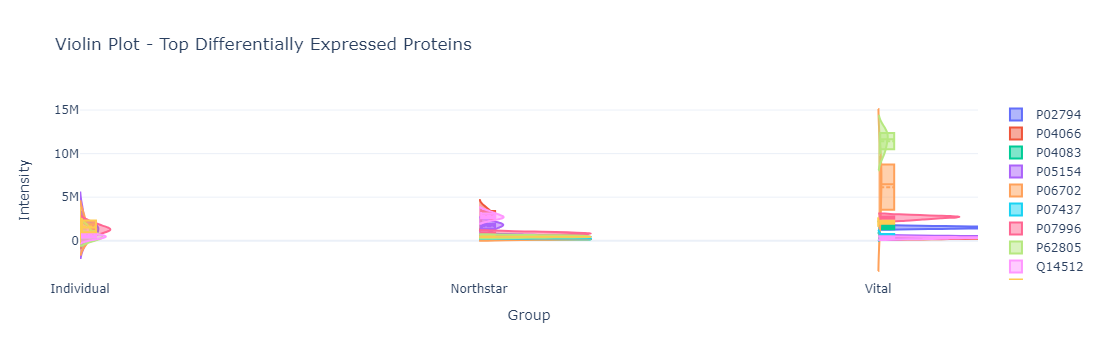

In [100]:
fig = go.Figure()

    # 7. Create a violin plot for each protein
for protein in top_10genes:
    protein_data = melted_df[melted_df['UniprotID'].str.contains(protein)]
    
    fig.add_trace(go.Violin(
        x=protein_data['Group'],
        y=protein_data['Intensity'],
        name=protein,
        box_visible=True,  # Show the boxplot within the violin plot
        meanline_visible=True,  # Show the mean line
        pointpos=0,  # Position of the scatter points
        jitter=0.05,  # Jitter for scatter points
        scalegroup=protein,
        side='positive'  # Plot only on one side of the axis
    ))

    # 8. Customize the layout of the plot, faceting by proteins
fig.update_layout(
    title=f"Violin Plot - Top Differentially Expressed Proteins",
    xaxis_title="Group",
    yaxis_title="Intensity",
    boxmode='group',
    violingap=0.2,  # Gap between violins
    violinmode='overlay',  # Overlay violins
    template='plotly_white'
)



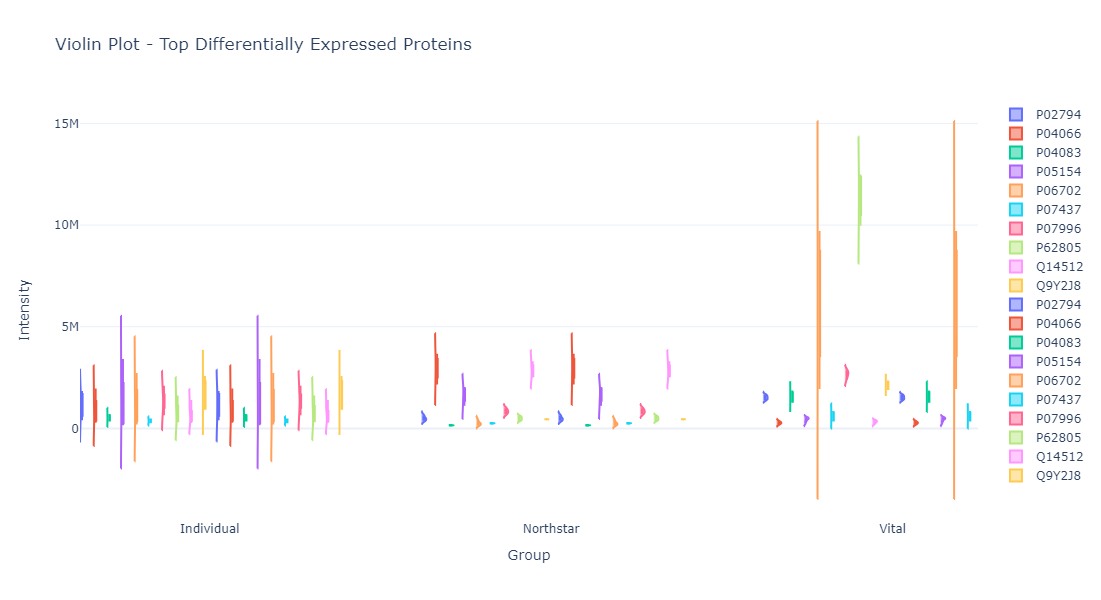

In [102]:
# 7. Add a separate violin plot for each protein
for protein in top_10genes:
    protein_data = melted_df[melted_df['UniprotID'].str.contains(protein)]

    fig.add_trace(go.Violin(
        x=protein_data['Group'],
        y=protein_data['Intensity'],
        name=protein,
        box_visible=True,  # Show the boxplot within the violin plot
        meanline_visible=True,  # Show the mean line
        pointpos=0,  # Position of the scatter points
        jitter=0.05,  # Jitter for scatter points
        scalegroup=protein,
        side='positive'  # Plot only on one side of the axis
    ))

    # Customize the layout of the plot, similar to the example you provided
fig.update_layout(
    title=f"Violin Plot - Top Differentially Expressed Proteins",
    xaxis_title="Group",
    yaxis_title="Intensity",
    violingap=0.2,  # Gap between violins
    violinmode='group',  # Group violins by protein
    template='plotly_white',
    height=600,  # Adjust the height of the plot
    width=1000  # Adjust the width to fit multiple proteins
)

In [94]:
df = pt_level.copy()
df = df.set_index('Protein')

In [109]:
top10genes = top_10genes

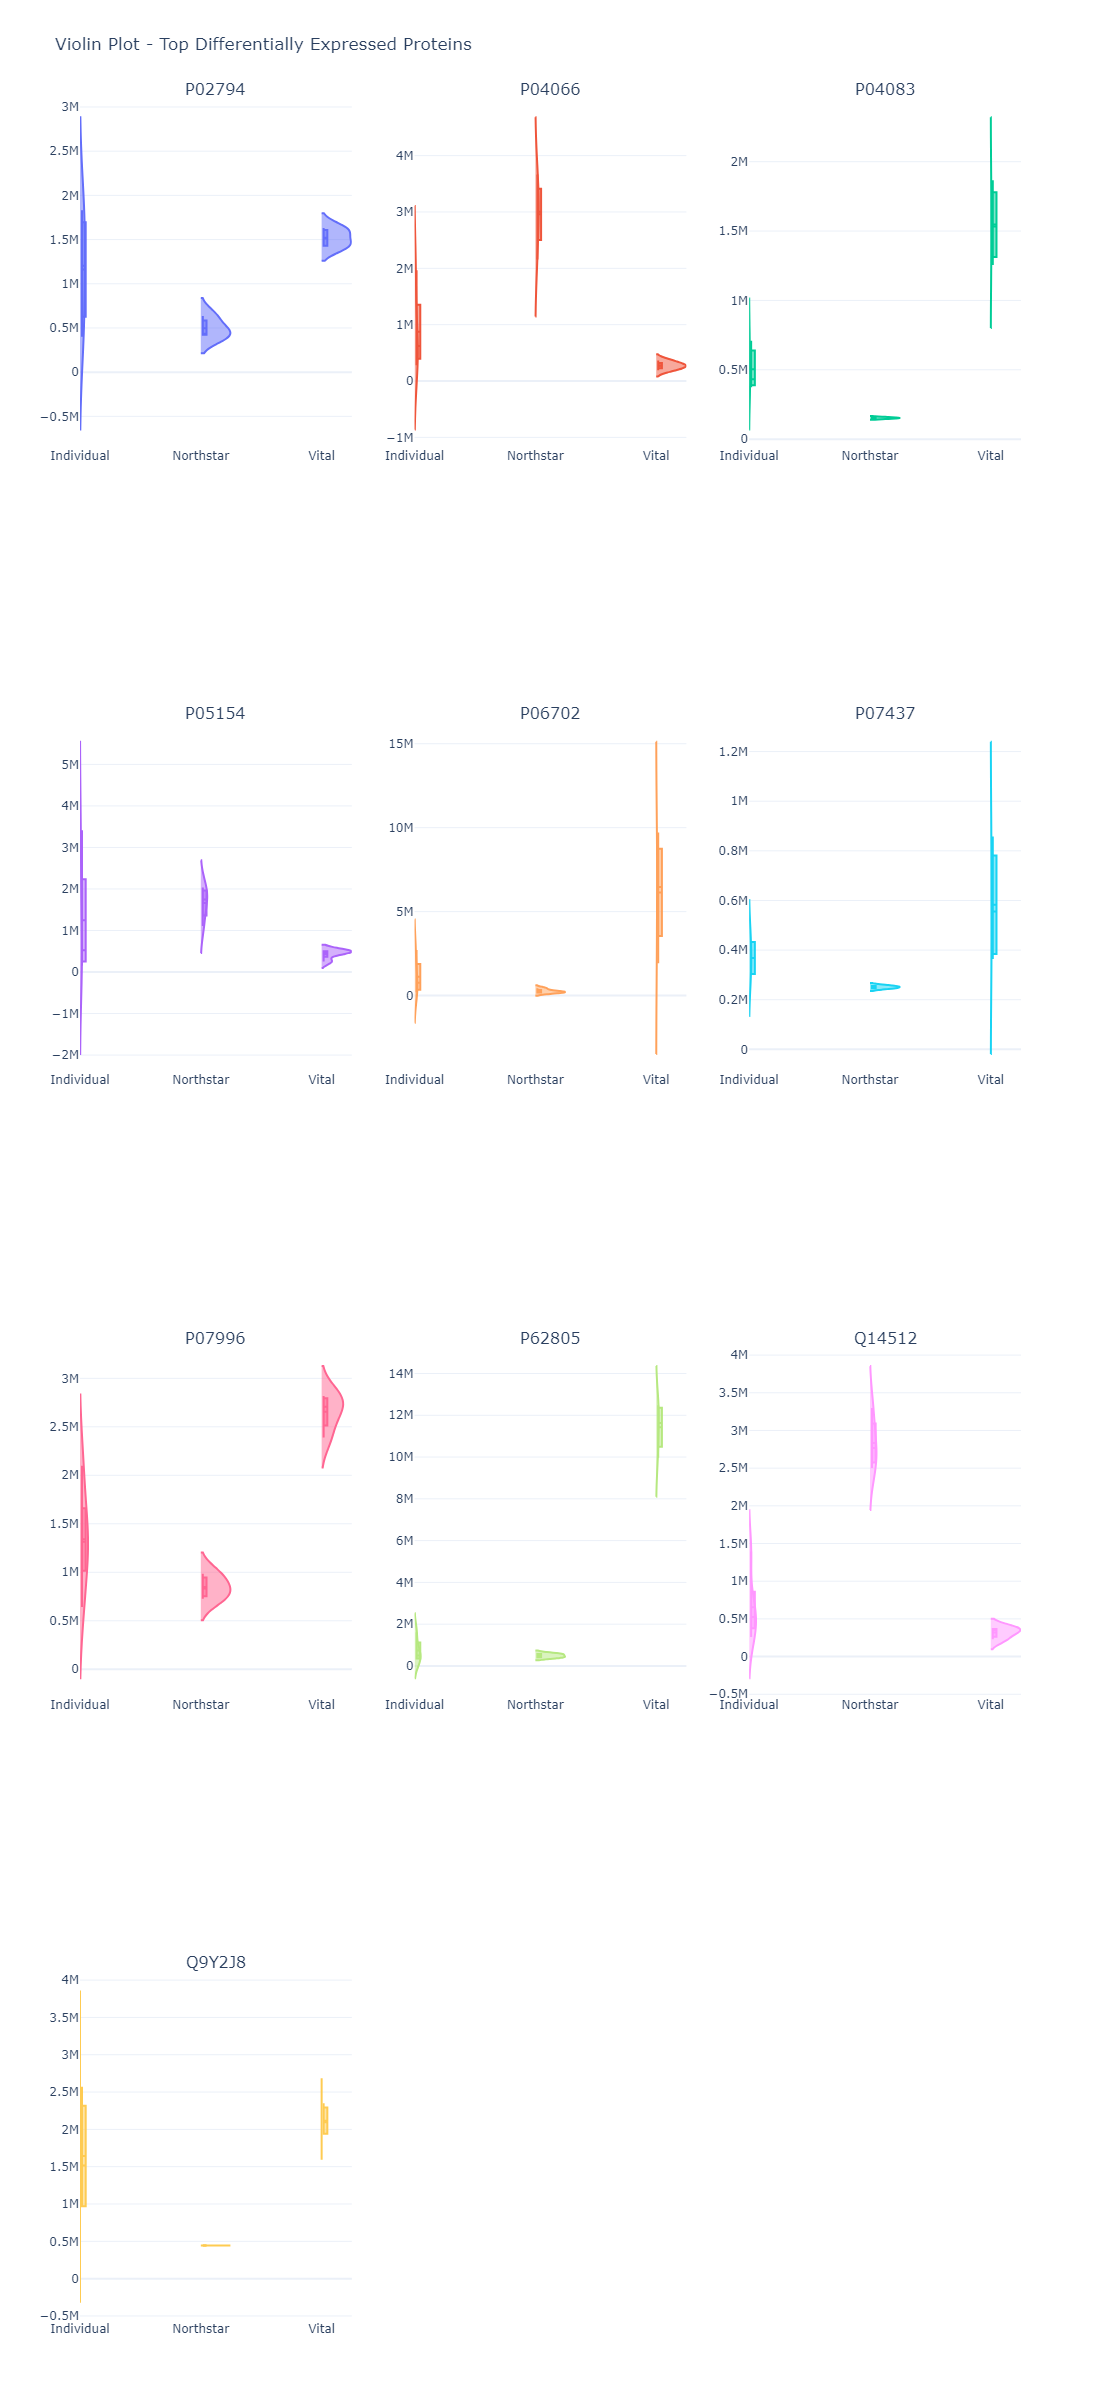

In [105]:
# 6. Create a subplot figure to hold individual violin plots for each protein
from plotly.subplots import make_subplots

num_proteins = len(top_10genes)
cols = 3  # Define the number of columns for the subplots
rows = (num_proteins // cols) + 1  # Calculate the number of rows based on the number of proteins

fig = make_subplots(rows=rows, cols=cols, subplot_titles=top_10genes)

# 7. Add a separate violin plot for each protein in its respective subplot
for i, protein in enumerate(top_10genes):
    protein_data = melted_df[melted_df['UniprotID'].str.contains(protein)]
    row = (i // cols) + 1
    col = (i % cols) + 1

    fig.add_trace(
        go.Violin(
            x=protein_data['Group'],
            y=protein_data['Intensity'],
            name=protein,
            box_visible=True,  # Show the boxplot within the violin plot
            meanline_visible=True,  # Show the mean line
            pointpos=0,  # Position of the scatter points
            jitter=0.05,  # Jitter for scatter points
            scalegroup=protein,
            side='positive'  # Plot only on one side of the axis
        ),
        row=row,
        col=col
    )

# Customize the layout of the plot, similar to the example you provided
fig.update_layout(
    title=f"Violin Plot - Top Differentially Expressed Proteins",
    height=600 * rows,  # Adjust the height based on the number of rows
    width=1000,  # Adjust the width of the plot
    showlegend=False,  # Turn off the legend
    template='plotly_white'
)

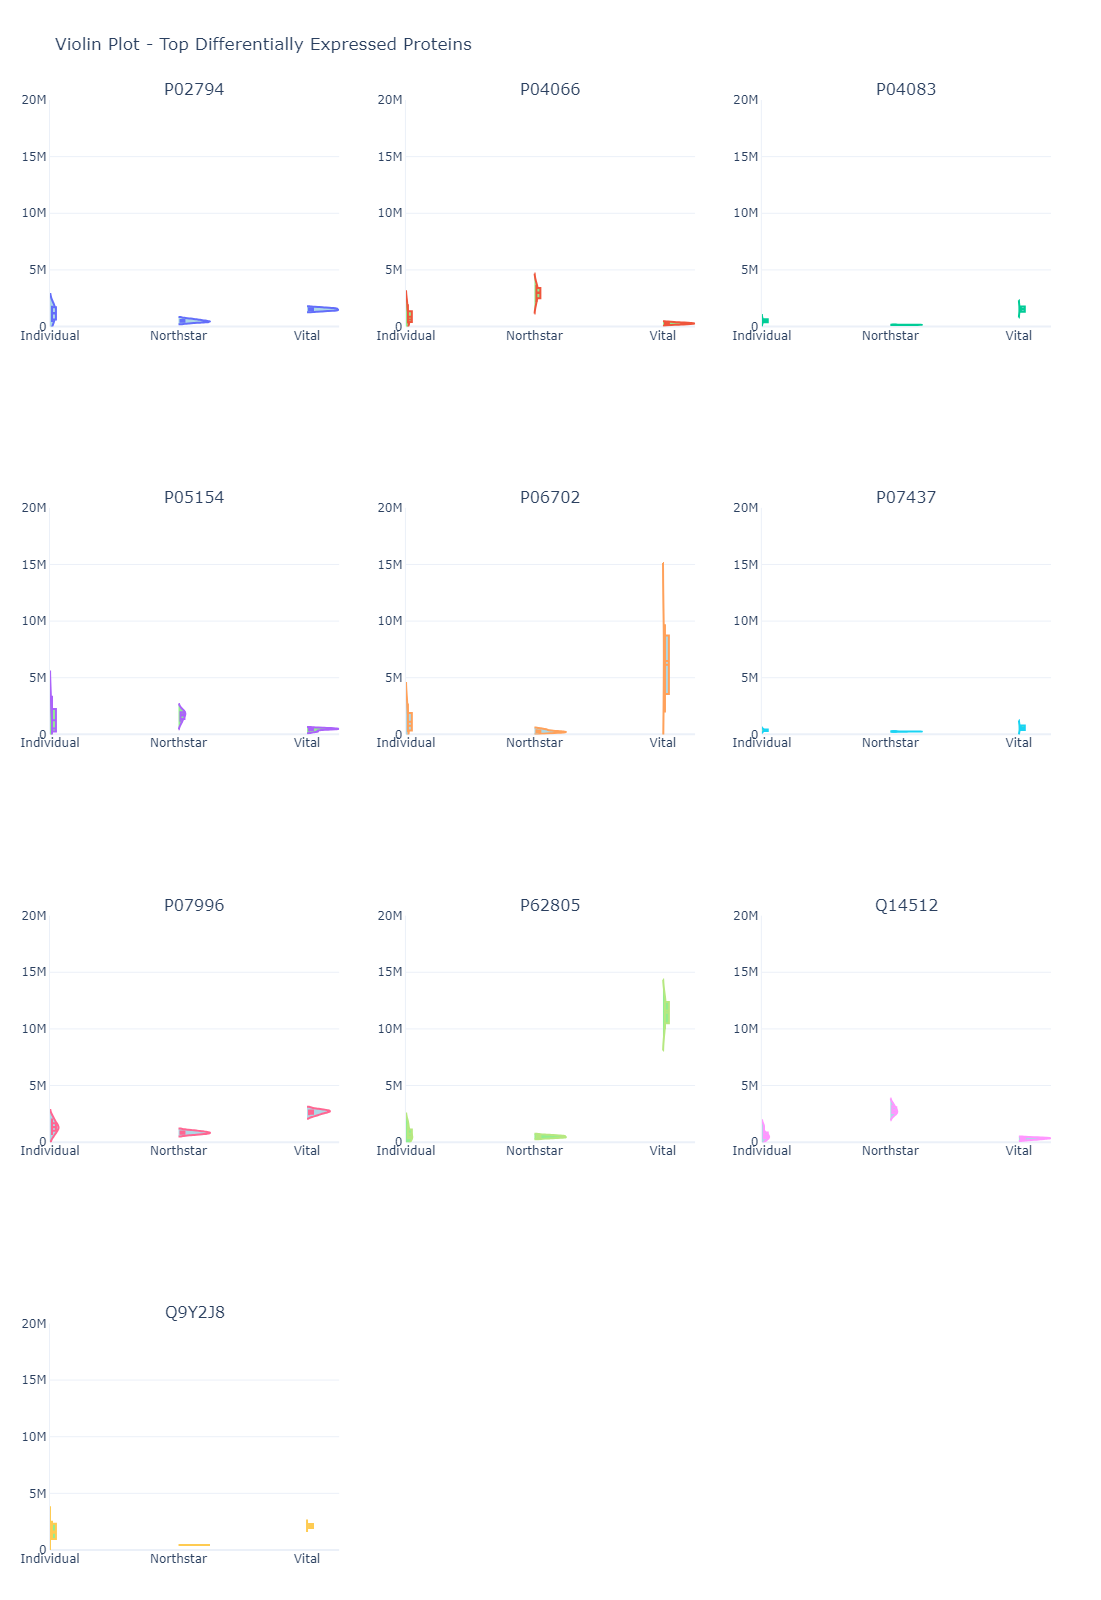

In [106]:
from plotly.subplots import make_subplots

num_proteins = len(top_10genes)
cols = 3  # Define the number of columns for the subplots
rows = (num_proteins // cols) + 1  # Calculate the number of rows based on the number of proteins

fig = make_subplots(rows=rows, cols=cols, subplot_titles=top_10genes)
for i, protein in enumerate(top_10genes):
        protein_data = melted_df[melted_df['UniprotID'].str.contains(protein)]
        row = (i // cols) + 1
        col = (i % cols) + 1

        fig.add_trace(
            go.Violin(
                x=protein_data['Group'],
                y=protein_data['Intensity'],
                name=protein,
                box_visible=True,  # Show the boxplot within the violin plot
                meanline_visible=True,  # Show the mean line
                pointpos=0,  # Position of the scatter points
                jitter=0.05,  # Jitter for scatter points
                scalegroup=protein,
                side='positive',  # Plot only on one side of the axis
                fillcolor="lightblue" if i % 2 == 0 else "lightgreen"  # Alternating colors
            ),
            row=row,
            col=col
        )

    # Customize the layout to be more compact and aligned with your shared snapshot
fig.update_layout(
    title=f"Violin Plot - Top Differentially Expressed Proteins",
    height=400 * rows,  # Adjust the height based on the number of rows
    width=1200,  # Adjust the width of the plot
    showlegend=False,  # Turn off the legend
    template='plotly_white',
    font=dict(size=12),  # Adjust font size
    margin=dict(l=50, r=50, t=100, b=50),  # Tighten margins
)

# Adjust y-axis range to match all subplots for better comparison
fig.update_yaxes(range=[0, 2e7], showline=True, zeroline=True)  # Set appropriate y-axis range for your data

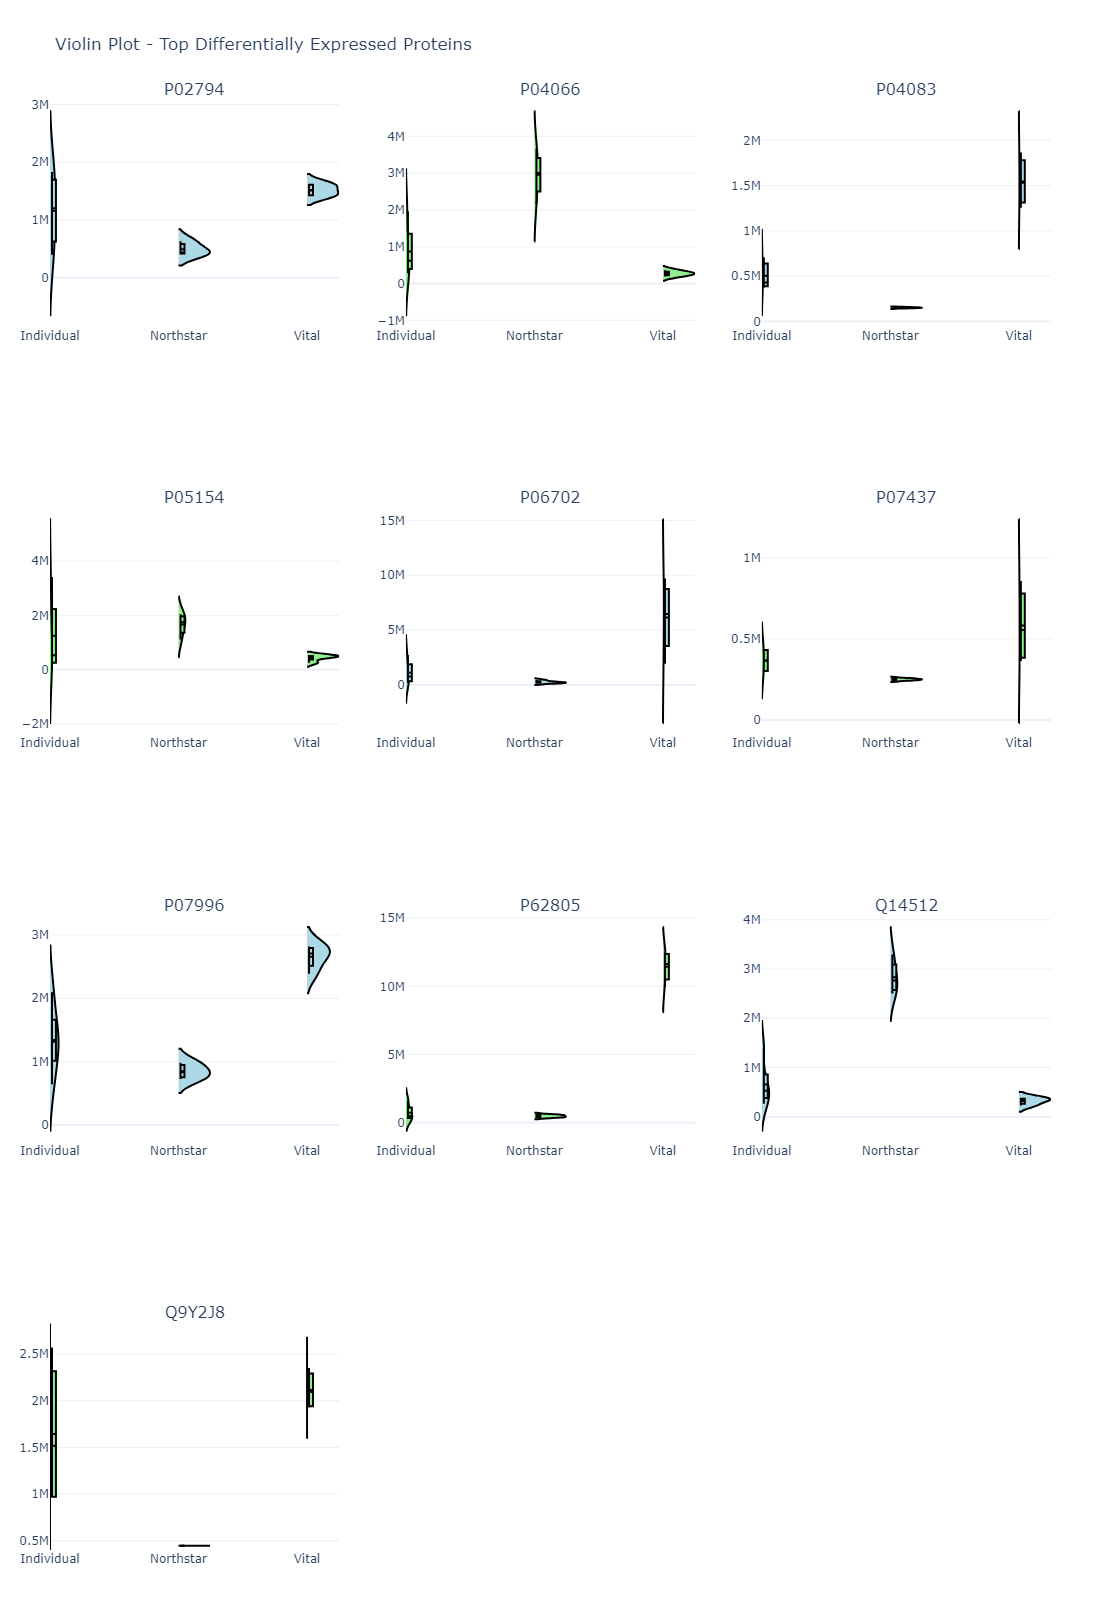

In [108]:
fig = make_subplots(rows=rows, cols=cols, subplot_titles=top_10genes)

    # 7. Add a separate violin plot for each protein in its respective subplot with dynamic y-axis ranges
for i, protein in enumerate(top_10genes):
    protein_data = melted_df[melted_df['UniprotID'].str.contains(protein)]
    row = (i // cols) + 1
    col = (i % cols) + 1

    # Get min and max values for y-axis dynamically
    y_min = protein_data['Intensity'].min()
    y_max = protein_data['Intensity'].max()

    fig.add_trace(
        go.Violin(
            x=protein_data['Group'],
            y=protein_data['Intensity'],
            name=protein,
            box_visible=True,  # Show the boxplot within the violin plot
            meanline_visible=True,  # Show the mean line
            pointpos=0,  # Position of the scatter points
            jitter=0.05,  # Jitter for scatter points
            scalegroup=protein,
            side='positive',  # Plot only on one side of the axis
            fillcolor="lightblue" if i % 2 == 0 else "lightgreen",  # Alternating colors
            line_color="black"  # Color for the box outline
        ),
        row=row,
        col=col
    )

    # Set dynamic y-axis range for each subplot
fig.update_yaxes(range=[y_min - y_min * 0.1, y_max + y_max * 0.1], row=row, col=col)

# Customize the layout to be more compact and aligned with your shared snapshot
fig.update_layout(
    title=f"Violin Plot - Top Differentially Expressed Proteins",
    height=400 * rows,  # Adjust the height based on the number of rows
    width=1200,  # Adjust the width of the plot
    showlegend=False,  # Turn off the legend
    template='plotly_white',
    font=dict(size=12),  # Adjust font size
    margin=dict(l=50, r=50, t=100, b=50),  # Tighten margins
)

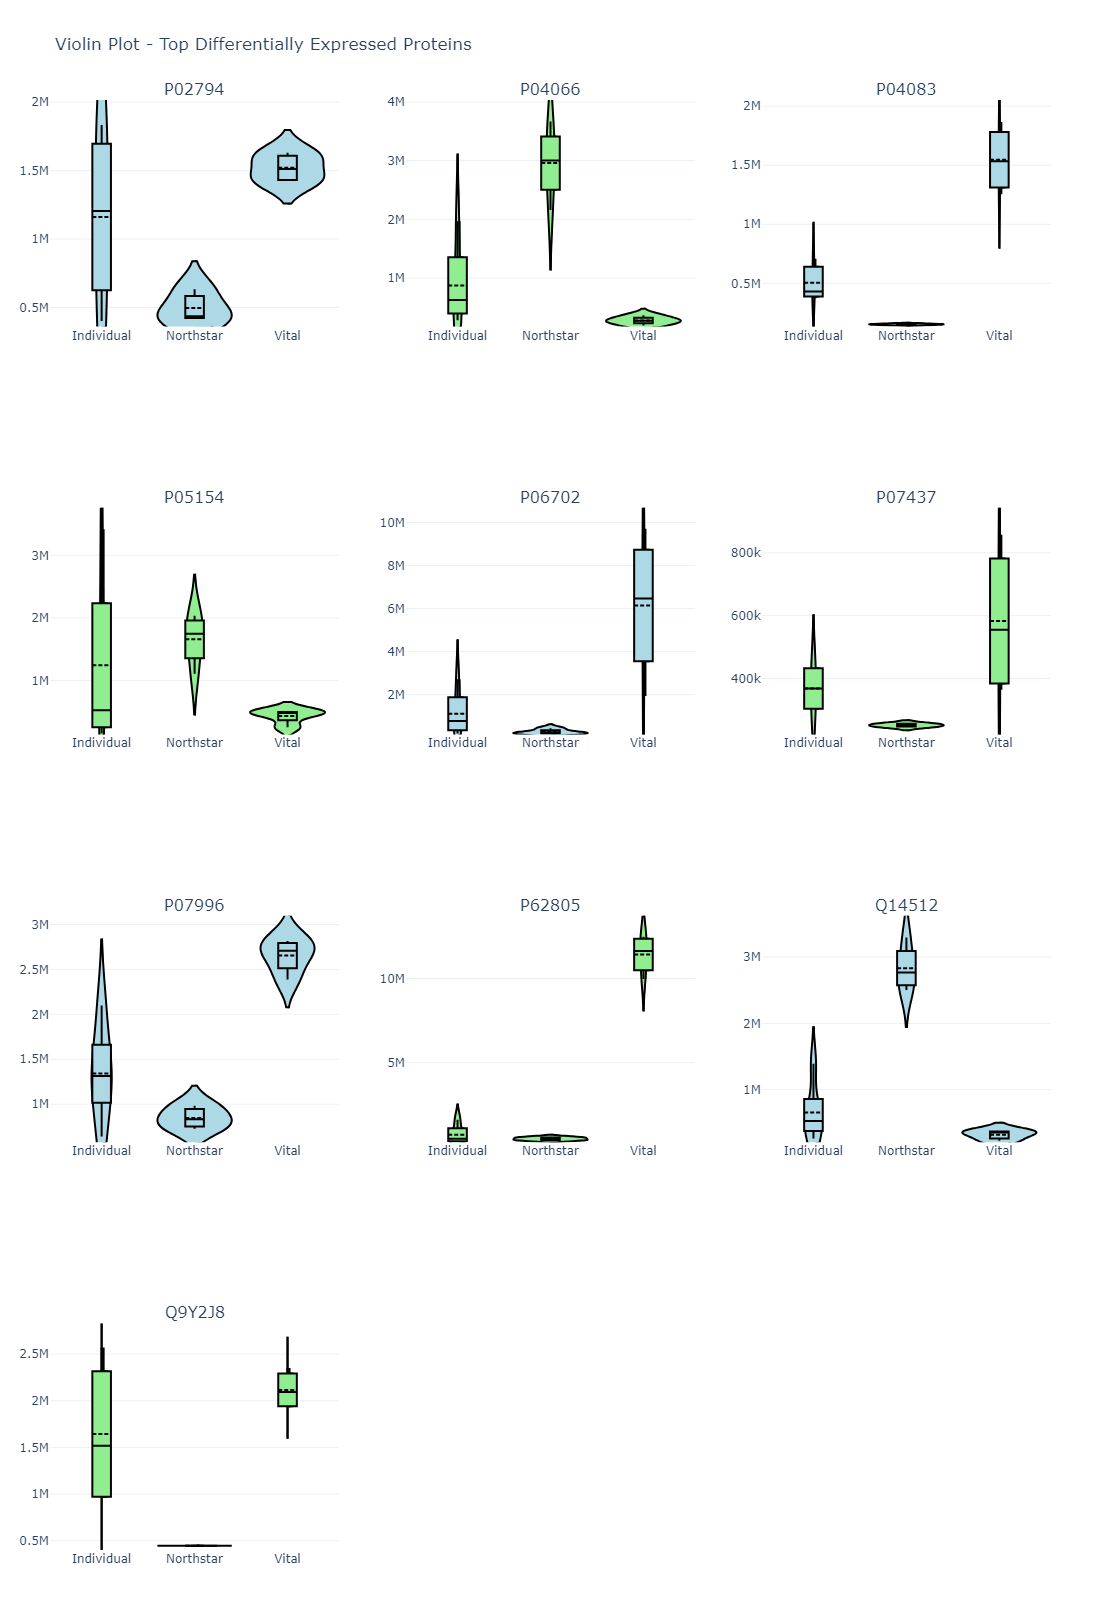

In [110]:
for i, protein in enumerate(top10genes):
    protein_data = melted_df[melted_df['UniprotID'].str.contains(protein)]
    row = (i // cols) + 1
    col = (i % cols) + 1

    # Get min and max values for y-axis dynamically
    y_min = protein_data['Intensity'].min()
    y_max = protein_data['Intensity'].max()

    fig.add_trace(
        go.Violin(
            x=protein_data['Group'],
            y=protein_data['Intensity'],
            name=protein,
            box_visible=True,  # Show the boxplot within the violin plot
            meanline_visible=True,  # Show the mean line
            pointpos=0,  # Position of the scatter points
            jitter=0.05,  # Jitter for scatter points
            scalegroup=protein,
            side='both',  # Plot on both sides of the axis for wider violin plots
            fillcolor="lightblue" if i % 2 == 0 else "lightgreen",  # Alternating colors
            line_color="black",  # Color for the box outline
            width=0.8  # Make the violin plots wider
        ),
        row=row,
        col=col
    )

    # Set dynamic y-axis range for each subplot
    fig.update_yaxes(range=[y_min - y_min * 0.1, y_max + y_max * 0.1], row=row, col=col)

# Customize the layout to be more compact and aligned with your shared snapshot
fig.update_layout(
    title=f"Violin Plot - Top Differentially Expressed Proteins",
    height=400 * rows,  # Adjust the height based on the number of rows
    width=1200,  # Adjust the width of the plot
    showlegend=False,  # Turn off the legend
    template='plotly_white',
    font=dict(size=12),  # Adjust font size
    margin=dict(l=50, r=50, t=100, b=50),  # Tighten margins
)

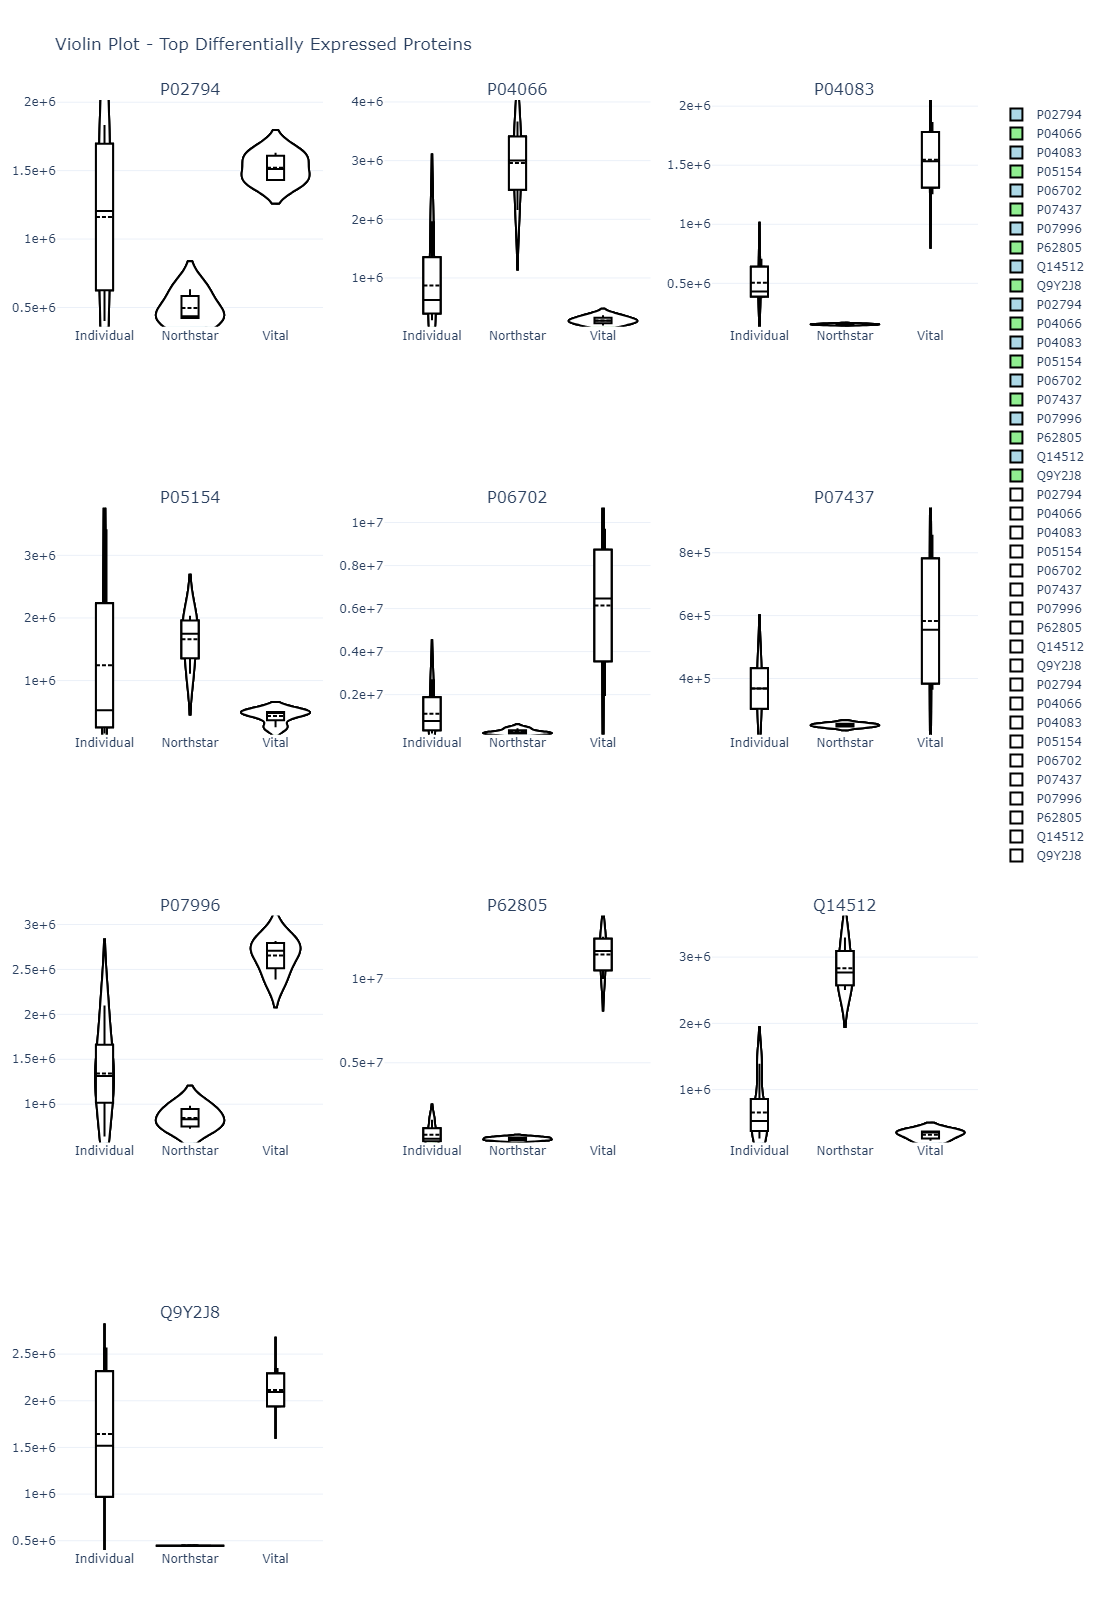

In [112]:
color_map = ['#D55E00', '#0072B2']

    # 7. Add a separate violin plot for each protein in its respective subplot with dynamic y-axis ranges
for i, protein in enumerate(top10genes):
    protein_data = melted_df[melted_df['UniprotID'].str.contains(protein)]
    row = (i // cols) + 1
    col = (i % cols) + 1

    # Get min and max values for y-axis dynamically
    y_min = protein_data['Intensity'].min()
    y_max = protein_data['Intensity'].max()
S
    fig.add_trace(
        go.Violin(
            x=protein_data['Group'],
            y=protein_data['Intensity'],
            name=protein,
            box_visible=True,  # Show the boxplot within the violin plot
            meanline_visible=True,  # Show the mean line
            pointpos=0,  # Position of the scatter points
            jitter=0.05,  # Jitter for scatter points
            scalegroup=protein,
            side='both',  # Plot on both sides of the axis for wider violin plots
            fillcolor="white",  # Set the box inside the violin plot to white
            line_color="black",  # Color for the box outline
            width=0.8,  # Make the violin plots wider
            box_fillcolor="white"  # White box for the middle
        ),
        row=row,
        col=col
    )

    # Set dynamic y-axis range for each subplot and apply scientific notation (1e6, 2e6, etc.)
    fig.update_yaxes(
        range=[y_min - y_min * 0.1, y_max + y_max * 0.1],
        row=row,
        col=col,
        exponentformat="e",  # Scientific notation
        showexponent='all'
    )

    # Customize the layout to match the shared snapshot
fig.update_layout(
    title=f"Violin Plot - Top Differentially Expressed Proteins",
    height=400 * rows,  # Adjust the height based on the number of rows
    width=1200,  # Adjust the width of the plot
    showlegend=True,  # Turn off the legend
    template='plotly_white',
    font=dict(size=12),  # Adjust font size
    margin=dict(l=50, r=50, t=100, b=50),  # Tighten margins
)

In [113]:
condition = "Individual vs Northstar"

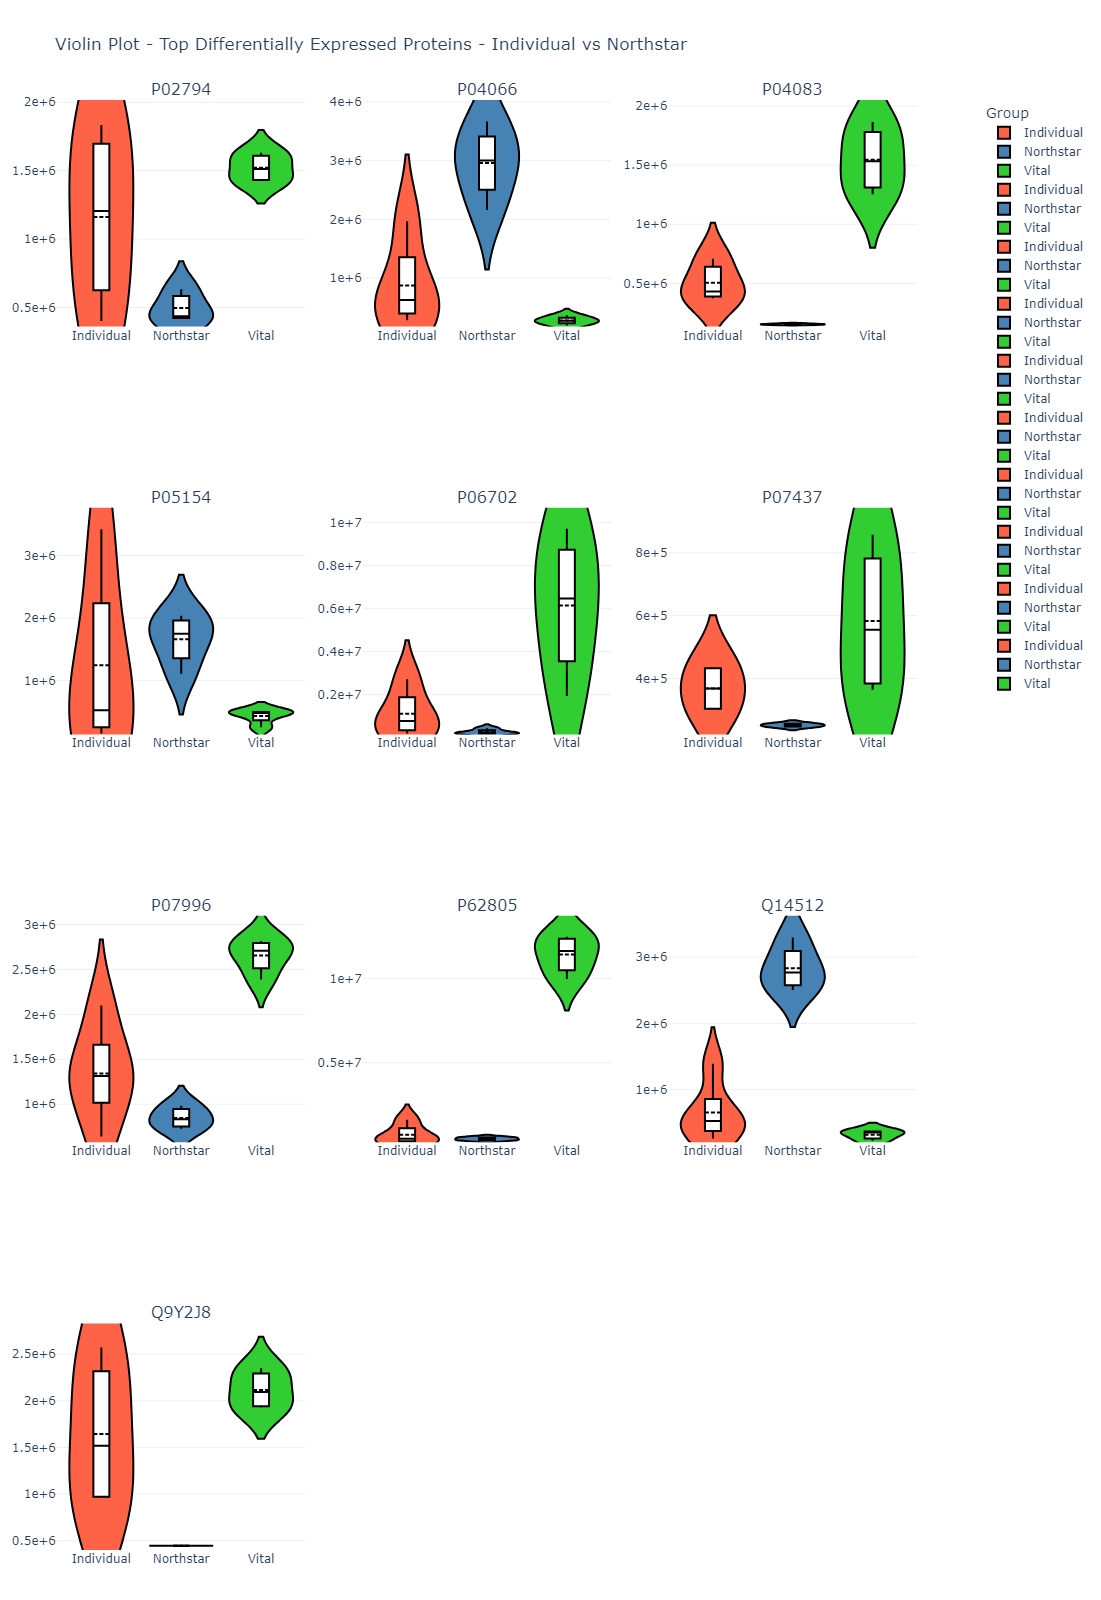

In [114]:
# 6. Create a subplot figure to hold individual violin plots for each protein
num_proteins = len(top10genes)
cols = 3  # Define the number of columns for the subplots
rows = (num_proteins // cols) + 1  # Calculate the number of rows based on the number of proteins

fig = make_subplots(rows=rows, cols=cols, subplot_titles=top10genes)

# Define three distinct colors for the groups: red, blue, and green
color_map = {
    'Individual': '#FF6347',  # Red
    'Northstar': '#4682B4',  # Blue
    'Vital': '#32CD32'  # Green
}

# 7. Add a separate violin plot for each protein in its respective subplot with dynamic y-axis ranges
for i, protein in enumerate(top10genes):
    protein_data = melted_df[melted_df['UniprotID'].str.contains(protein)]
    row = (i // cols) + 1
    col = (i % cols) + 1

    # Get min and max values for y-axis dynamically
    y_min = protein_data['Intensity'].min()
    y_max = protein_data['Intensity'].max()

    for group in protein_data['Group'].unique():
        group_data = protein_data[protein_data['Group'] == group]

        fig.add_trace(
            go.Violin(
                x=group_data['Group'],
                y=group_data['Intensity'],
                name=group,
                box_visible=True,  # Show the boxplot within the violin plot
                meanline_visible=True,  # Show the mean line
                pointpos=0,  # Position of the scatter points
                jitter=0.05,  # Jitter for scatter points
                scalegroup=protein,
                side='both',  # Plot on both sides of the axis for wider violin plots
                fillcolor=color_map[group],  # Apply the group-specific color
                line_color="black",  # Color for the box outline
                width=0.8,  # Make the violin plots wider
                box_fillcolor="white"  # White box for the middle
            ),
            row=row,
            col=col
        )

    # Set dynamic y-axis range for each subplot and apply scientific notation (1e6, 2e6, etc.)
    fig.update_yaxes(
        range=[y_min - y_min * 0.1, y_max + y_max * 0.1],
        row=row,
        col=col,S
        exponentformat="e",  # Scientific notation
        showexponent='all'
    )

# Add the legend manually to show color associations
fig.update_layout(
    title=f"Violin Plot - Top Differentially Expressed Proteins - {condition}",
    height=400 * rows,  # Adjust the height based on the number of rows
    width=1200,  # Adjust the width of the plot
    showlegend=True,
    legend=dict(
        title="Group",
        itemsizing='constant',
        font=dict(size=12),
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.2
    ),
    template='plotly_white',
    font=dict(size=12),  # Adjust font size
    margin=dict(l=50, r=50, t=100, b=50),  # Tighten margins
)

In [115]:
analysis_withAnnotation

ProteinIds Gene Name                                Protein Description  \
0     A0A075B6I0  IGLV8-61                Immunoglobulin lambda variable 8-61   
1     A0A075B6J9  IGLV2-18                Immunoglobulin lambda variable 2-18   
2     A0A075B6Q5  IGHV3-64                 Immunoglobulin heavy variable 3-64   
3     A0A075B6R2   IGHV4-4                  Immunoglobulin heavy variable 4-4   
4     A0A0A0MS15  IGHV3-49                 Immunoglobulin heavy variable 3-49   
...          ...       ...                                                ...   
1769      Q9Y646       CPQ  Carboxypeptidase Q (EC 3.4.17.-) (Lysosomal di...   
1770      Q9Y678     COPG1  Coatomer subunit gamma-1 (Gamma-1-coat protein...   
1771      Q9Y696     CLIC4  Chloride intracellular channel protein 4 (Glut...   
1772      Q9Y6B6     SAR1B  Small COPII coat GTPase SAR1B (EC 3.6.5.2) (GT...   
1773      Q9Y6Y9      LY96  Lymphocyte antigen 96 (Ly-96) (ESOP-1) (Protei...   

                                     Tissue Specificity  \
0                                                         
1                                                         
2                                                         
3                                                         
4                                                         
...                                                 ...   
1769  TISSUE SPECIFICITY: Mainly detected in blood p...   
1770                                                      
1771  TISSUE SPECIFICITY: Detected in epithelial cel...   
1772  TISSUE SPECIFICITY: Expressed in many tissues ...   
1773                                                      

                     Gene ontology (biological process)  \
0     adaptive immune response [GO:0002250]; immune ...   
1     adaptive immune response [GO:0002250]; immune ...   
2     immunoglobulin mediated immune response [GO:00...   
3     immunoglobulin mediated immune response [GO:00...   
4     immunoglobulin mediated immune response [GO:00...   
...                                                 ...   
1769  peptide catabolic process [GO:0043171]; proteo...   
1770  endoplasmic reticulum to Golgi vesicle-mediate...   
1771  angiogenesis [GO:0001525]; branching morphogen...   
1772  antigen processing and presentation of peptide...   
1773  cell surface receptor signaling pathway [GO:00...   

                     Gene ontology (cellular component)  \
0     extracellular space [GO:0005615]; immunoglobul...   
1     extracellular space [GO:0005615]; immunoglobul...   
2     extracellular region [GO:0005576]; immunoglobu...   
3     extracellular region [GO:0005576]; immunoglobu...   
4     extracellular region [GO:0005576]; immunoglobu...   
...                                                 ...   
1769  cytoplasm [GO:0005737]; endoplasmic reticulum ...   
1770  COPI vesicle coat [GO:0030126]; cytosol [GO:00...   
1771  actin cytoskeleton [GO:0015629]; apical part o...   
1772  COPII vesicle coat [GO:0030127]; cytosol [GO:0...   
1773  endosome membrane [GO:0010008]; extracellular ...   

                     Gene ontology (molecular function)  \
0                                                         
1                                                         
2                          antigen binding [GO:0003823]   
3                          antigen binding [GO:0003823]   
4                          antigen binding [GO:0003823]   
...                                                 ...   
1769  carboxypeptidase activity [GO:0004180]; metal ...   
1770          structural molecule activity [GO:0005198]   
1771  chloride channel activity [GO:0005254]; oxidor...   
1772  amino acid sensor activity [GO:0140785]; G pro...   
1773  coreceptor activity [GO:0015026]; lipopolysacc...   

                               Subcellular Location[CC]     Protein  \
0     SUBCELLULAR LOCATION: Secreted {ECO:0000303|Pu...  A0A075B6I0   
1     SUBCELLULAR LOCATION: Secreted {ECO:0000303|Pu...

In [116]:
import dash_bio as dashbio
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

def plot_heatmap(df, annotation_info, group_column='Group', cluster_column='Cluster', height=600, width=800):
    """
    Create a heatmap using dash-bio Clustergram with scaled intensities, cluster annotations, and groupings.
    Args:
        df: The DataFrame containing the protein expression data (rows = proteins, columns = samples)
        annotation_info: The DataFrame containing annotation details for each sample
        group_column: The column in annotation_info representing the groups (e.g., 'Control', 'Disease')
        cluster_column: The column representing de novo cluster assignment
    Returns:
        fig: A Dash Bio Clustergram plot object
    """
    # Scale the data (normalization)
    df = df.set_index('Protein')  # Set the index to 'Protein'
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    
    # Prepare annotation information
    sample_names = df.columns  # Assuming the columns are sample names
    annotation_info = annotation_info.set_index('SampleName')

    # Map colors to the groups in the annotation info
    unique_groups = annotation_info[group_column].unique()
    group_colors = px.colors.qualitative.Set1[:len(unique_groups)]  # Choose a color palette for the groups
    group_color_map = {group: color for group, color in zip(unique_groups, group_colors)}

    group_annotations = [group_color_map[annotation_info.loc[sample, group_column]] for sample in sample_names]

    # Map cluster assignment to colors
    cluster_colors = ['orange', 'green', 'blue']
    cluster_assignments = [cluster_colors[annotation_info.loc[sample, cluster_column]] for sample in sample_names]

    # Create the clustergram
    fig = dashbio.Clustergram(
        data=df_scaled.values,
        row_labels=df_scaled.index,
        column_labels=sample_names,
        color_map=[
            [0.0, 'rgb(255, 255, 255)'],
            [0.5, 'rgb(255, 192, 203)'],  # Light pink for mid values
            [1.0, 'rgb(255, 0, 0)'],      # Dark red for high values
        ],
        column_group_marker=dict(
            groups=[{
                'annotation': 'Group',
                'group': annotation_info[group_column].tolist(),
                'color': group_annotations
            }]
        ),
        row_group_marker=dict(
            groups=[{
                'annotation': 'Cluster',
                'group': annotation_info[cluster_column].tolist(),
                'color': cluster_assignments
            }]
        ),
        height=height,
        width=width,
        display_ratio=[0.1, 0.3]  # Adjusts row and column label ratio
    )

    return fig

In [119]:
fig = plot_heatmap(top_10_df, annotation_info, group_column='Group', cluster_column='Cluster')

KeyError: 'Cluster'

In [136]:
def plot_heatmap(top_10_df, annotation_info_with_cluster):
        """
        Plot heatmap of top 10 differentially expressed proteins with group annotation and cluster assignment.

        Parameters:
            - top_10_df: DataFrame with intensity values for the top 10 proteins (rows are proteins, columns are samples).
            - annotation_info_with_cluster: DataFrame containing sample names, group annotations, and cluster assignments.
        """
        # Set 'Protein' as the index if not already done
        if 'Protein' in top_10_df.columns:
            top_10_df.set_index('Protein', inplace=True)

        # Ensure the columns of the intensity dataframe match the samples in the annotation_info_with_cluster
        if not set(top_10_df.columns).issubset(annotation_info_with_cluster['SampleName']):
            raise ValueError("Sample names in the intensity data do not match with the annotation info.")

        # Step 1: Create color mappings for groups and clusters
        group_colors = {
            'Northstar': 'blue', 
            'Vital': 'green', 
            'Individual': 'red'
        }
        
        # Generate unique colors for clusters (e.g., cluster 0, 1, 2)
        cluster_palette = sns.color_palette("husl", annotation_info_with_cluster['Cluster'].nunique())
        cluster_colors = {cluster: color for cluster, color in zip(annotation_info_with_cluster['Cluster'].unique(), cluster_palette)}

        # Step 2: Map the annotations and cluster assignments to the heatmap columns
        sample_to_group_color = annotation_info_with_cluster.set_index('SampleName')['Group'].map(group_colors)
        sample_to_cluster_color = annotation_info_with_cluster.set_index('SampleName')['Cluster'].map(cluster_colors)

        # Step 3: Prepare colors for heatmap
        col_colors = pd.DataFrame({
            'Group': sample_to_group_color,
            'Cluster': sample_to_cluster_color
        })

        # Step 4: Plot the heatmap with group and cluster colors
        sns.clustermap(
            top_10_df, 
            cmap="RdBu_r", 
            standard_scale=1,  # Standardize each protein row
            row_cluster=True,  # Cluster proteins
            col_cluster=True,  # Cluster samples
            col_colors=col_colors,  # Add annotation coloring
            figsize=(12, 8)
        )

        plt.title("Heatmap - Top DEPs")
        plt.show()

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

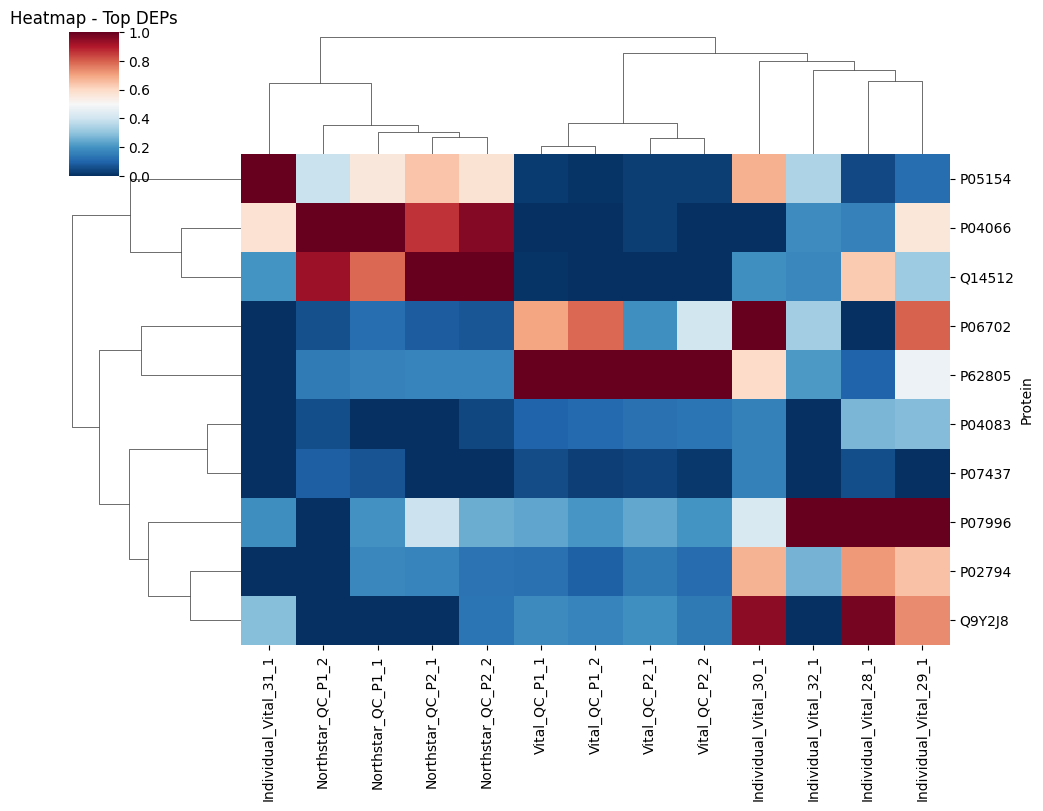

<Figure size 1200x800 with 0 Axes>

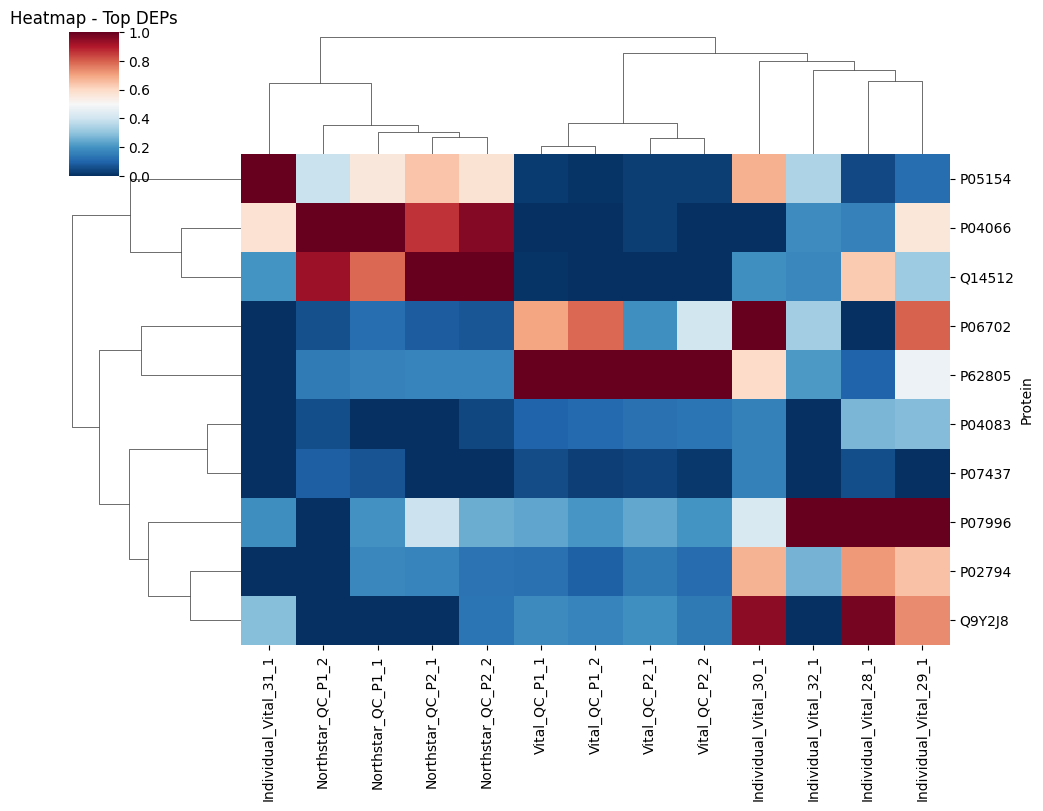

In [134]:
plot_heatmap(top_10_df, )

In [132]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline